In [1]:
# run in a notebook cell with a leading ! or in terminal
!pip install --upgrade pip
!pip install datasets ultralytics paddlepaddle paddleocr easyocr opencv-python-headless matplotlib pillow tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 MB 63.2 MB/s  0:00:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 65.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 33.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 63.9 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 117.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 166.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 141.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 115.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 64.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [44]:
import os, json
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Load and Parse CORD Dataset

In [45]:
# Load dataset
ds = load_dataset("naver-clova-ix/cord-v2")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})


Extract Text and Labels

In [46]:
def extract_text_labels_from_sample(sample):
    gt = json.loads(sample['ground_truth'])
    gt_parse = gt.get('gt_parse', {})
    texts, labels = [], []

    # Menu items
    if 'menu' in gt_parse:
        for item in gt_parse['menu']:
            if isinstance(item, dict):
                cnt = item.get('cnt','')
                nm  = item.get('nm','')
                price = item.get('price','')
                combined = f"{cnt} {nm} {price}".strip()
                if combined:
                    texts.append(combined)
                    labels.append('menu_item')

    # Subtotal / Total / Service / Tax / etc
    for key in ['sub_total', 'total', 'service_price', 'tax_price', 'etc']:
        val = gt_parse.get(key)
        if val:
            if isinstance(val, dict):
                for k,v in val.items():
                    texts.append(f"{k}: {v}")
                    labels.append(k)
            else:
                texts.append(f"{key}: {val}")
                labels.append(key)

    return texts, labels


In [47]:
sample = ds['train'][0]
texts, labels = extract_text_labels_from_sample(sample)
print(len(texts), texts[:5])
print(labels[:5])

27 ['1 x Nasi Campur Bali 75,000', '1 x Bbk Bengil Nasi 125,000', '1 x MilkShake Starwb 37,000', '1 x Ice Lemon Tea 24,000', '1 x Nasi Ayam Dewata 70,000']
['menu_item', 'menu_item', 'menu_item', 'menu_item', 'menu_item']


Build Dataset Lists

In [48]:
def build_text_label_lists(dataset_split):
    all_texts, all_labels = [], []
    for sample in tqdm(dataset_split):
        t, l = extract_text_labels_from_sample(sample)
        all_texts.extend(t)
        all_labels.extend(l)
    return all_texts, all_labels

train_texts, train_labels = build_text_label_lists(ds['train'])
test_texts, test_labels = build_text_label_lists(ds['test'])
print("Train samples:", len(train_texts))
print("Test samples:", len(test_texts))


100%|██████████| 100/100 [00:04<00:00, 21.75it/s]

Train samples: 5130
Test samples: 619


Clean & Merge Rare Classes

In [49]:
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})

# Merge ultra-rare labels
train_df['label'] = train_df['label'].replace({
    'othersvc_price': 'etc',
    'sub_total': 'subtotal_price'
})
test_df['label'] = test_df['label'].replace({
    'othersvc_price': 'etc',
    'sub_total': 'subtotal_price'
})

print(train_df['label'].value_counts())


label
menu_item          1759
total_price         779
subtotal_price      530
cashprice           517
changeprice         500
tax_price           354
menuqty_cnt         228
creditcardprice     121
service_price        98
etc                  69
discount_price       61
emoneyprice          46
menutype_cnt         42
total_etc            26
Name: count, dtype: int64


Encode Labels & Vectorize Text

In [50]:
# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Classes:", label_encoder.classes_)


Train shape: (5130, 3000)
Test shape: (619, 3000)
Classes: ['cashprice' 'changeprice' 'creditcardprice' 'discount_price'
 'emoneyprice' 'etc' 'menu_item' 'menuqty_cnt' 'menutype_cnt'
 'service_price' 'subtotal_price' 'tax_price' 'total_etc' 'total_price']


Compute Class Weights (Fix Imbalance)

In [51]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:\n", class_weight_dict)


Class Weights:
 {0: np.float64(0.7087593257806024), 1: np.float64(0.7328571428571429), 2: np.float64(3.0283353010625738), 3: np.float64(6.007025761124122), 4: np.float64(7.96583850931677), 5: np.float64(5.3105590062111805), 6: np.float64(0.208316413546658), 7: np.float64(1.6071428571428572), 8: np.float64(8.724489795918368), 9: np.float64(3.739067055393586), 10: np.float64(0.6913746630727763), 11: np.float64(1.0351089588377724), 12: np.float64(14.093406593406593), 13: np.float64(0.47038327526132406)}


Build a Simple Classifier (using Keras)

In [52]:
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │     1,536,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,671,438 (6.38 MB)

 Trainable params: 1,671,438 (6.38 MB)

 Non-trainable params: 0 (0.00 B)

Prepare Labels & Train Model

In [53]:
y_train_encoded = to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_test_encoded = to_categorical(y_test, num_classes=len(label_encoder.classes_))

history = model.fit(
    X_train.toarray(), y_train_encoded,
    validation_data=(X_test.toarray(), y_test_encoded),
    epochs=20,
    batch_size=32,
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4649 - loss: 2.6740 - val_accuracy: 1.0000 - val_loss: 0.7314
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9850 - loss: 0.5574 - val_accuracy: 1.0000 - val_loss: 0.4154
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9998 - loss: 0.3781 - val_accuracy: 1.0000 - val_loss: 0.3474
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9992 - loss: 0.3084 - val_accuracy: 1.0000 - val_loss: 0.2760
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9999 - loss: 0.2644 - val_accuracy: 1.0000 - val_loss: 0.2501
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.2354 - val_accuracy: 1.0000 - val_loss: 0.2221
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9996 - loss: 0.2187 - val_accuracy: 1.0000 - val_loss: 0.2024
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9998 - loss: 0.2089 - val_accuracy: 1

Evaluate Model

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Classification Report:

                 precision    recall  f1-score   support

      cashprice       1.00      1.00      1.00        67
    changeprice       1.00      1.00      1.00        56
creditcardprice       1.00      1.00      1.00        16
 discount_price       1.00      1.00      1.00         6
    emoneyprice       1.00      1.00      1.00         1
            etc       1.00      1.00      1.00         7
      menu_item       1.00      1.00      1.00       212
    menuqty_cnt       1.00      1.00      1.00        29
   menutype_cnt       1.00      1.00      1.00         7
  service_price       1.00      1.00      1.00        12
 subtotal_price       1.00      1.00      1.00        65
      tax_price       1.00      1.00      1.00        43
      total_etc       1.00      1.00      1.00         3
    total_price       1.00      1.00      1.00        95

       accuracy                           1.00       619
      macro avg      

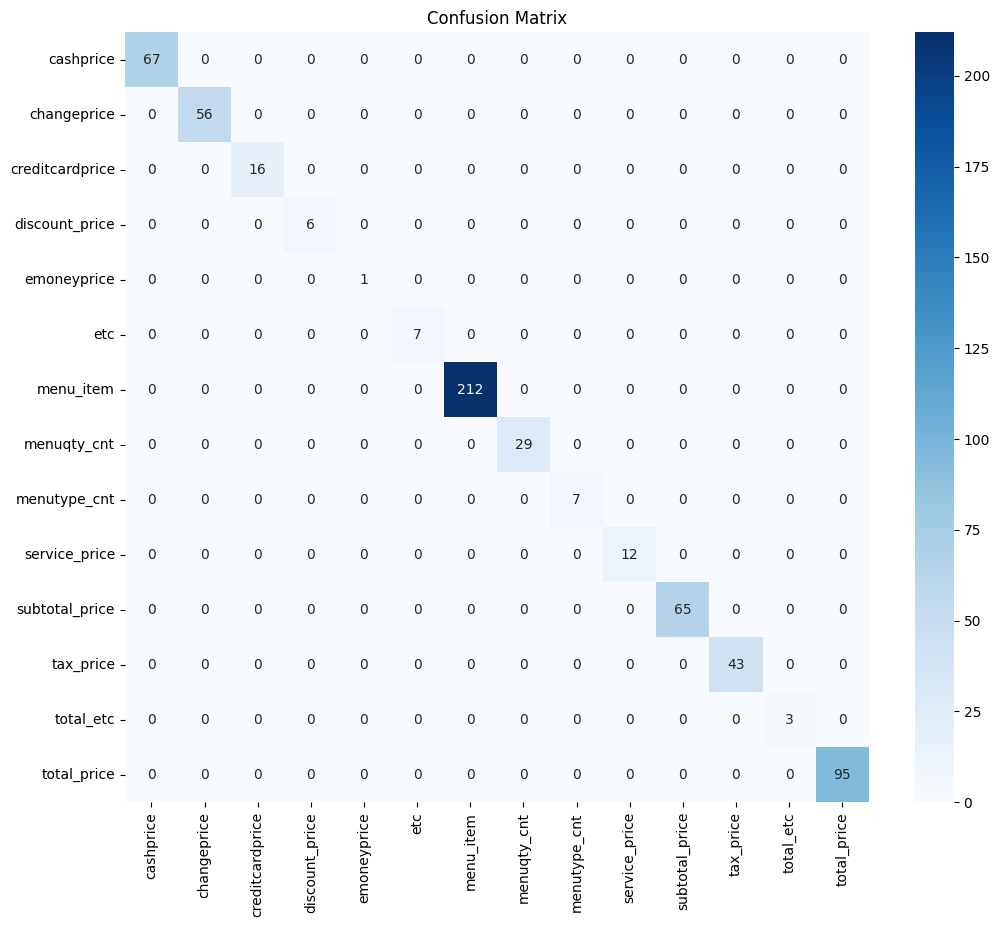

In [54]:
y_pred = np.argmax(model.predict(X_test.toarray()), axis=1)

print("\nClassification Report:\n")
print(classification_report(
    y_test, y_pred, target_names=label_encoder.classes_
))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.show()


In [55]:
import joblib

model.save("invoice_classifier.h5")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("✅ Model and artifacts saved!")


✅ Model and artifacts saved!
